# Data Analysis Notebook 

This notebook is designed for the purpose of analyzing data obtained from the Hydra cluster. It provides a set of tools and techniques for performing data analysis tasks and extracting insights from the data.


## EE of the Cut for large range of system sizes


In [24]:
Sys.CPU_THREADS

6

In [25]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
dep_path = "../AdditionalStructure/Julia/"
include("$(dep_path)NewTypes.jl")
include("$(dep_path)BitStringOps.jl")
include("$(dep_path)Measurements.jl")
include("$(dep_path)MICModels.jl")
include("$(dep_path)ModelRuns.jl")
include("$(dep_path)HelperTools.jl")
include("$(dep_path)Iterators.jl");


In [26]:
function give_type(data)
    return (data["L"], data["p_b"], data["p_f"])
end

give_type (generic function with 1 method)

In [27]:
exp_index = 14
dir_extension = ""
file_prefix = "out/"
filename = "../Remote-Hydra/Toric_Code/data$(dir_extension)/$(file_prefix)TEE_exp:$(exp_index).h5"
data = h5read(filename, "/")

all_data = []

model_data_dict = Dict()

for exp_index in 1:800
    filename = "../Remote-Hydra/Toric_Code/data$(dir_extension)/$(file_prefix)TEE_exp:$(exp_index).h5"
    if ispath(filename)
        data = h5read(filename, "/")
        # print(data["L"],",")
        push!(all_data, data)
        model_data_dict[(data["L"], data["p_b"], data["p_f"])] = data
    end
end
print("data sets read: ",length(all_data))

all_sizes = sort(collect(keys(model_data_dict)))

Data_dict = Dict()

for data in all_data
    L, p_b, p_f = give_type(data)
    Data_dict[L] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    p_b = round(p_b, digits=5)
    p_f = round(p_f, digits=5)
    Data_dict[L][(p_b, p_f)] = Dict(
        "mean" => Dict(
            "EE_cut" => mean(data["EE_cut"]),
            "TEE" => mean(data["TEE"]),
            "Fermion_Fermion" => mean(data["Fermion_Fermion"]),
            "Boson_Boson" => mean(data["Boson_Boson"]),
            "Other_Boson_Boson" => mean(data["Other_Boson_Boson"]),
            "TEN" => mean(data["TEN"]),
            ),
        "var" => Dict(
            "EE_cut" => std(data["EE_cut"]),
            "TEE" => std(data["TEE"]),
            "Fermion_Fermion" => std(data["Fermion_Fermion"]),
            "Boson_Boson" => std(data["Boson_Boson"]),
            "Other_Boson_Boson" => std(data["Other_Boson_Boson"]),
            "TEN" => std(data["TEN"]),
            ),
        "median" => Dict(
            "EE_cut" => median(data["EE_cut"]),
            "TEE" => median(data["TEE"]),
            "Fermion_Fermion" => median(data["Fermion_Fermion"]),
            "Boson_Boson" => median(data["Boson_Boson"]),
            "Other_Boson_Boson" => median(data["Other_Boson_Boson"]),
            "TEN" => median(data["TEN"]),
            ),
        "err" => Dict(
            "EE_cut" => std(data["EE_cut"])/sqrt(length(data["EE_cut"])),
            "TEE" => std(data["TEE"])/sqrt(length(data["TEE"])),
            "Fermion_Fermion" => std(data["Fermion_Fermion"])/sqrt(length(data["Fermion_Fermion"])),
            "Boson_Boson" => std(data["Boson_Boson"])/sqrt(length(data["Boson_Boson"])),
            "Other_Boson_Boson" => std(data["Other_Boson_Boson"])/sqrt(length(data["Other_Boson_Boson"])),
            "TEN" => std(data["TEN"])/sqrt(length(data["TEN"])),
            )
        )
end

Data_dict_extra = deepcopy(Data_dict)

data sets read: 231

Dict{Any, Any} with 1 entry:
  30 => Dict{Any, Any}((0.5, 0.0)=>Dict("median"=>Dict("Fermion_Fermion"=>0.0, …

In [28]:

exp_index = 1
dir_extension = "_z"
file_prefix = "out/"
filename = "../Remote-Hydra/Toric_Code/data$(dir_extension)/$(file_prefix)TEE_exp:$(exp_index).h5"
data = h5read(filename, "/")

for key in keys(data)
    println("$key: $(data[key])")
end


exp_index: 1
p_b: 0.0
TEE: [3, 5, 3, 3, 7, 3, 3, 1, 4, 5]
p_f: 0.75
L: 10
sys_type: Init_EdgeSquareLattice_KitaevDoNuT
EE_cut: [0 18 24 25 26 26 27 27 27 20 0; 0 17 29 29 26 26 26 28 26 20 0; 0 18 25 26 27 28 27 28 25 17 0; 0 18 28 28 31 30 29 29 29 19 0; 0 18 27 26 28 29 30 30 30 19 0; 0 18 28 29 27 28 31 29 28 19 0; 0 15 27 29 28 28 28 25 26 16 0; 0 18 27 27 24 26 28 29 27 18 0; 0 18 28 27 30 29 28 25 26 20 0; 0 15 23 25 25 28 26 29 27 17 0]
t_mmt: [70, 90, 110, 130, 150, 170, 190, 210, 230, 250]
Fermion_Fermion: [1 1 1 1 1 0 0 0 0 0; 1 1 1 0 1 1 1 1 1 1; 1 0 1 0 1 0 1 1 1 1; 1 1 0 1 0 0 0 0 0 1; 1 0 1 0 1 1 0 1 0 1; 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1; 1 0 0 0 0 0 0 0 0 0; 1 0 1 0 0 0 0 0 1 1; 1 1 0 0 1 1 1 1 0 1;;; 1 1 1 1 1 1 1 0 1 0; 1 1 1 1 1 1 0 0 1 1; 1 0 1 1 1 1 1 0 1 1; 0 0 0 0 0 0 0 0 0 1; 1 1 0 0 0 1 0 1 0 0; 1 1 1 1 1 1 0 0 1 1; 1 0 1 0 1 1 1 1 1 1; 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0;;; 1 1 1 1 1 1 1 0 0 0; 1 1 1 1 1 0 1 0 1 1; 1 1 1 1 0 1 

In [29]:
all_data = []

model_data_dict = Dict()

for exp_index in 1:800
    filename = "../Remote-Hydra/Toric_Code/data$(dir_extension)/$(file_prefix)TEE_exp:$(exp_index).h5"
    if ispath(filename)
        data = h5read(filename, "/")
        # print(data["L"],",")
        push!(all_data, data)
        model_data_dict[(data["L"], data["p_b"], data["p_f"])] = data
    end
end
print("data sets read: ",length(all_data))

all_sizes = sort(collect(keys(model_data_dict)))

data sets read: 214

4-element Vector{Any}:
 (10, 0.0, 0.75)
 (10, 0.1, 0.75)
 (22, 0.0, 0.75)
 (22, 0.1, 0.75)

In [30]:
model_data_dict[(22, 0.0, 0.75)]

Dict{String, Any} with 13 entries:
  "exp_index"       => 443
  "p_b"             => 0.0
  "TEE"             => [3, 2, 1, 2, 2, 2, 3, 2, 3, 1]
  "p_f"             => 0.75
  "L"               => 22
  "sys_type"        => "Init_EdgeSquareLattice_KitaevDoNuT"
  "EE_cut"          => [0 37 … 40 0; 0 41 … 40 0; … ; 0 38 … 39 0; 0 40 … 41 0]
  "t_mmt"           => [70, 90, 110, 130, 150, 170, 190, 210, 230, 250]
  "Fermion_Fermion" => [1 0 … 0 0; 1 0 … 1 1; … ; 1 1 … 1 0; 1 0 … 0 1;;; 0 0 ……
  "Boson_Boson"     => [1 0 … 0 0; 1 0 … 0 0; … ; 1 0 … 0 0; 1 0 … 0 0;;; 0 0 ……
  "filename"        => "/mnt/users/jovanovic/GitHub/Subsystem-Code-Physics/Remo…
  "description"     => "Single Points in the Phase Diagram, Zassenhausen fermi-…
  "d"               => 1

In [31]:
CUT_dict_helper = Dict(
    size_key => [] for size_key in keys(model_data_dict)
)

for data in all_data
    size_key = give_type(data)
    push!(CUT_dict_helper[size_key], permutedims(data["EE_cut"],(2,1)))
end

CUT_dict = Dict()

for size_key in all_sizes
    CUT_dict[size_key] = cat(dims= 2, CUT_dict_helper[size_key]...)
end

CUT_means = Dict()
CUT_vars = Dict()
CUT_errs = Dict()
CUT_medians = Dict()

for size_key in all_sizes
    CUT_means[size_key] = mean(CUT_dict[size_key], dims = 2)
    CUT_vars[size_key] = var(CUT_dict[size_key], dims = 2)
    CUT_errs[size_key] = std(CUT_dict[size_key], dims = 2) / sqrt(size(CUT_dict[size_key], 2))
    CUT_medians[size_key] = median(CUT_dict[size_key], dims = 2)
end

CUT_Stats = Dict(
    "mean" => CUT_means,
    "var" => CUT_vars,
    "err" => CUT_errs,
    "median" => CUT_medians
)

Dict{String, Dict{Any, Any}} with 4 entries:
  "median" => Dict((10, 0.0, 0.75)=>[0.0; 17.0; … ; 18.0; 0.0;;], (10, 0.1, 0.7…
  "err"    => Dict((10, 0.0, 0.75)=>[0.0; 0.058808; … ; 0.0588677; 0.0;;], (10,…
  "mean"   => Dict((10, 0.0, 0.75)=>[0.0; 17.3754; … ; 17.5895; 0.0;;], (10, 0.…
  "var"    => Dict((10, 0.0, 0.75)=>[0.0; 1.97128; … ; 1.97528; 0.0;;], (10, 0.…

In [32]:
TEE_dict_helper = Dict(
    size_key => [] for size_key in keys(model_data_dict)
)

for data in all_data
    size_key = give_type(data)
    push!(TEE_dict_helper[size_key], data["TEE"])
end

TEE_dict = Dict()

for size_key in all_sizes
    TEE_dict[size_key] = cat(dims= 1, TEE_dict_helper[size_key]...)
end

TEE_means = Dict()
TEE_vars = Dict()
TEE_errs = Dict()
TEE_medians = Dict()

for size_key in all_sizes
    TEE_means[size_key] = mean(TEE_dict[size_key], dims = 1)
    TEE_vars[size_key] = var(TEE_dict[size_key], dims = 1)
    TEE_errs[size_key] = std(TEE_dict[size_key], dims = 1) / sqrt(size(TEE_dict[size_key], 1))
    TEE_medians[size_key] = median(TEE_dict[size_key], dims = 1)
end

TEE_Stats = Dict(
    "mean" => TEE_means,
    "var" => TEE_vars,
    "err" => TEE_errs,
    "median" => TEE_medians
)

Dict{String, Dict{Any, Any}} with 4 entries:
  "median" => Dict((10, 0.0, 0.75)=>[3.0], (10, 0.1, 0.75)=>[18.0], (22, 0.0, 0…
  "err"    => Dict((10, 0.0, 0.75)=>[0.0533784], (10, 0.1, 0.75)=>[0.171046], (…
  "mean"   => Dict((10, 0.0, 0.75)=>[3.10175], (10, 0.1, 0.75)=>[17.631], (22, …
  "var"    => Dict((10, 0.0, 0.75)=>[1.62407], (10, 0.1, 0.75)=>[16.969], (22, …

In [33]:
TEE_Stats["mean"]

Dict{Any, Any} with 4 entries:
  (10, 0.0, 0.75) => [3.10175]
  (10, 0.1, 0.75) => [17.631]
  (22, 0.0, 0.75) => [2.17551]
  (22, 0.1, 0.75) => [60.404]

In [34]:
function add_corr_data!(corr_dic, corr_table, L, metric = taxi_metrix_torus)
    
    if length(corr_dic) == 0
        all_r = []
        for i = 1:L
            for j = 1:L
                x_i = i - 1
                y_i = j - 1
                push!(all_r, metric((0, 0), (x_i, y_i), L, L))
            end
        end
        
        for r in all_r
            corr_dic[r] = []
        end
    end # Creates a dictionary keys if corr_dic is empty. The arrays are still empty.

    for i = 1:L
        for j = 1:L
            x_i = i - 1
            y_i = j - 1
            r = metric((0, 0), (x_i, y_i), L, L)
            push!(corr_dic[r], corr_table[i, j])
        end
    end

    return corr_dic
end

function get_corr_stats(corr_dic)

    r_s = sort(collect(keys(corr_dic)))

    corr_stats = Dict(
        "x_axis" => r_s,
        "mean" => [mean(corr_dic[r]) for r in r_s],
        "median" => [median(corr_dic[r]) for r in r_s],
        "var" => [var(corr_dic[r]) for r in r_s],
        "err" => [std(corr_dic[r]) / sqrt(length(corr_dic[r])) for r in r_s]
    )

    return corr_stats
end

get_corr_stats (generic function with 1 method)

In [35]:
FF_dict_all = Dict()

for data in all_data
    FF_dict_all[give_type(data)] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    t_mmt = data["t_mmt"]
    for i_t = 1:length(t_mmt)
        add_corr_data!(FF_dict_all[(L, p_b, p_f)], data["Fermion_Fermion"][i_t, :, :], L)
    end
end

FF_stats = Dict()

for key in keys(FF_dict_all)
    FF_stats[key] = get_corr_stats(FF_dict_all[key])
end

BB_dict_all = Dict()

for data in all_data
    BB_dict_all[give_type(data)] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    t_mmt = data["t_mmt"]
    for i_t = 1:length(t_mmt)
        add_corr_data!(BB_dict_all[(L, p_b, p_f)], data["Boson_Boson"][i_t, :, :], L)
    end
end

BB_stats = Dict()

for key in keys(BB_dict_all)
    BB_stats[key] = get_corr_stats(BB_dict_all[key])
end

In [36]:
function add_corr_data_2d!(corr_dic, corr_table, L, metric = taxi_metrix_torus)
    
    if length(corr_dic) == 0
        all_r = []
        for i = 1:L
            for j = 1:L
                x_i = i - 1
                y_i = j - 1
                push!(all_r, (x_i, y_i))
            end
        end
        
        for r in all_r
            corr_dic[r] = []
        end
    end # Creates a dictionary keys if corr_dic is empty. The arrays are still empty.

    for i = 1:L
        for j = 1:L
            x_i = i - 1
            y_i = j - 1
            r = (x_i, y_i)
            push!(corr_dic[r], corr_table[i, j])
        end
    end

    return corr_dic
end

function get_corr_stats_2d(corr_dic)

    r_s = sort(collect(keys(corr_dic)))

    corr_stats = Dict(
        "xy_axis" => r_s,
        "mean" => [mean(corr_dic[r]) for r in r_s],
        "median" => [median(corr_dic[r]) for r in r_s],
        "var" => [var(corr_dic[r]) for r in r_s],
        "err" => [std(corr_dic[r]) / sqrt(length(corr_dic[r])) for r in r_s]
    )

    return corr_stats
end

get_corr_stats_2d (generic function with 1 method)

In [37]:
FF_dict_all_2d = Dict()

for data in all_data
    FF_dict_all_2d[give_type(data)] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    t_mmt = data["t_mmt"]
    for i_t = 1:length(t_mmt)
        add_corr_data_2d!(FF_dict_all_2d[(L, p_b, p_f)], data["Fermion_Fermion"][i_t, :, :], L)
    end
end

FF_stats_2d = Dict()

for key in keys(FF_dict_all_2d)
    FF_stats_2d[key] = get_corr_stats_2d(FF_dict_all_2d[key])
end

BB_dict_all_2d = Dict()

for data in all_data
    BB_dict_all_2d[give_type(data)] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    t_mmt = data["t_mmt"]
    for i_t = 1:length(t_mmt)
        add_corr_data_2d!(BB_dict_all_2d[(L, p_b, p_f)], data["Boson_Boson"][i_t, :, :], L)
    end
end

BB_stats_2d = Dict()

for key in keys(BB_dict_all_2d)
    BB_stats_2d[key] = get_corr_stats_2d(BB_dict_all_2d[key])
end

In [38]:
stat = "mean"
ribbon = "err"
probe = 5
p_1 = plot(title = "Fermion-Fermion Correlation Functions", xlabel = "r", ylabel = "Fermi_Fermi")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
ribbon = "err"

p_2 = plot(title = "Boson-Boson Correlation Functions", xlabel = "r", ylabel = "Boson_Boson")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
variable = "TEE"
cut_off = 4
L, p_b, p_f = all_sizes[probe]
L = 30

N = 21
to_map = fill(NaN, N, N)

for key in keys(Data_dict_extra[L])
    p_b, p_f = key
    i = Int(round(p_b*(N-1)))
    j = Int(round(p_f*(N-1)))
    to_map[i + 1, j + 1] = min(Data_dict_extra[L][key][stat][variable], cut_off)
end

p_b = [i/(N-1) for i in 0:(N-1)]
p_f = [i/(N-1) for i in 0:(N-1)]
p_3 = heatmap(p_b, p_f, to_map', aspect_ratio=1, c=:viridis, xlabel="p_b", ylabel="p_f", title="L = $L, $stat $variable", cbar = false)
L, p_b, p_f = all_sizes[probe]
p_3 = scatter!([p_b], [p_f], markersize = 5, legend = false, color = :red, label = "p_b = $p_b, p_f = $p_f")



plot(p_1, p_2, p_3, layout = (1,3), size = (1500, 500), title= "", dpi = 300, legend = false, left_margin = 10Plots.mm, right_margin = 10Plots.mm, top_margin = 10Plots.mm, bottom_margin = 10Plots.mm)
#savefig("Plots/Corr_Funcs_Probe:$(probe).pdf")

BoundsError: BoundsError: attempt to access 4-element Vector{Any} at index [[5]]

In [39]:
stat = "mean"
ribbon = "err"
probe = 6
p_1 = plot(title = "Fermion-Fermion Correlation Functions", xlabel = "r", ylabel = "Fermi_Fermi")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
ribbon = "err"

p_2 = plot(title = "Boson-Boson Correlation Functions", xlabel = "r", ylabel = "Boson_Boson")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
variable = "TEE"
cut_off = 4
L, p_b, p_f = all_sizes[probe]
L = 30

N = 21
to_map = fill(NaN, N, N)

for key in keys(Data_dict_extra[L])
    p_b, p_f = key
    i = Int(round(p_b*(N-1)))
    j = Int(round(p_f*(N-1)))
    to_map[i + 1, j + 1] = min(Data_dict_extra[L][key][stat][variable], cut_off)
end

p_b = [i/(N-1) for i in 0:(N-1)]
p_f = [i/(N-1) for i in 0:(N-1)]
p_3 = heatmap(p_b, p_f, to_map', aspect_ratio=1, c=:viridis, xlabel="p_b", ylabel="p_f", title="L = $L, $stat $variable", cbar = false)
L, p_b, p_f = all_sizes[probe]
p_3 = scatter!([p_b], [p_f], markersize = 5, legend = false, color = :red, label = "p_b = $p_b, p_f = $p_f")



plot(p_1, p_2, p_3, layout = (1,3), size = (1500, 500), title= "", dpi = 300, legend = false, left_margin = 10Plots.mm, right_margin = 10Plots.mm, top_margin = 10Plots.mm, bottom_margin = 10Plots.mm)
#savefig("Plots/Corr_Funcs_Probe:$(probe).pdf")

BoundsError: BoundsError: attempt to access 4-element Vector{Any} at index [[6]]

In [40]:
stat = "mean"
ribbon = "err"
probe = 7
p_1 = plot(title = "Fermion-Fermion Correlation Functions", xlabel = "r", ylabel = "Fermi_Fermi")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
ribbon = "err"

p_2 = plot(title = "Boson-Boson Correlation Functions", xlabel = "r", ylabel = "Boson_Boson")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
variable = "TEE"
cut_off = 4
L, p_b, p_f = all_sizes[probe]
L = 30

N = 21
to_map = fill(NaN, N, N)

for key in keys(Data_dict_extra[L])
    p_b, p_f = key
    i = Int(round(p_b*(N-1)))
    j = Int(round(p_f*(N-1)))
    to_map[i + 1, j + 1] = min(Data_dict_extra[L][key][stat][variable], cut_off)
end

p_b = [i/(N-1) for i in 0:(N-1)]
p_f = [i/(N-1) for i in 0:(N-1)]
p_3 = heatmap(p_b, p_f, to_map', aspect_ratio=1, c=:viridis, xlabel="p_b", ylabel="p_f", title="L = $L, $stat $variable", cbar = false)
L, p_b, p_f = all_sizes[probe]
p_3 = scatter!([p_b], [p_f], markersize = 5, legend = false, color = :red, label = "p_b = $p_b, p_f = $p_f")



plot(p_1, p_2, p_3, layout = (1,3), size = (1500, 500), title= "", dpi = 300, legend = false, left_margin = 10Plots.mm, right_margin = 10Plots.mm, top_margin = 10Plots.mm, bottom_margin = 10Plots.mm)
#savefig("Plots/Corr_Funcs_Probe:$(probe).pdf")

BoundsError: BoundsError: attempt to access 4-element Vector{Any} at index [[7]]

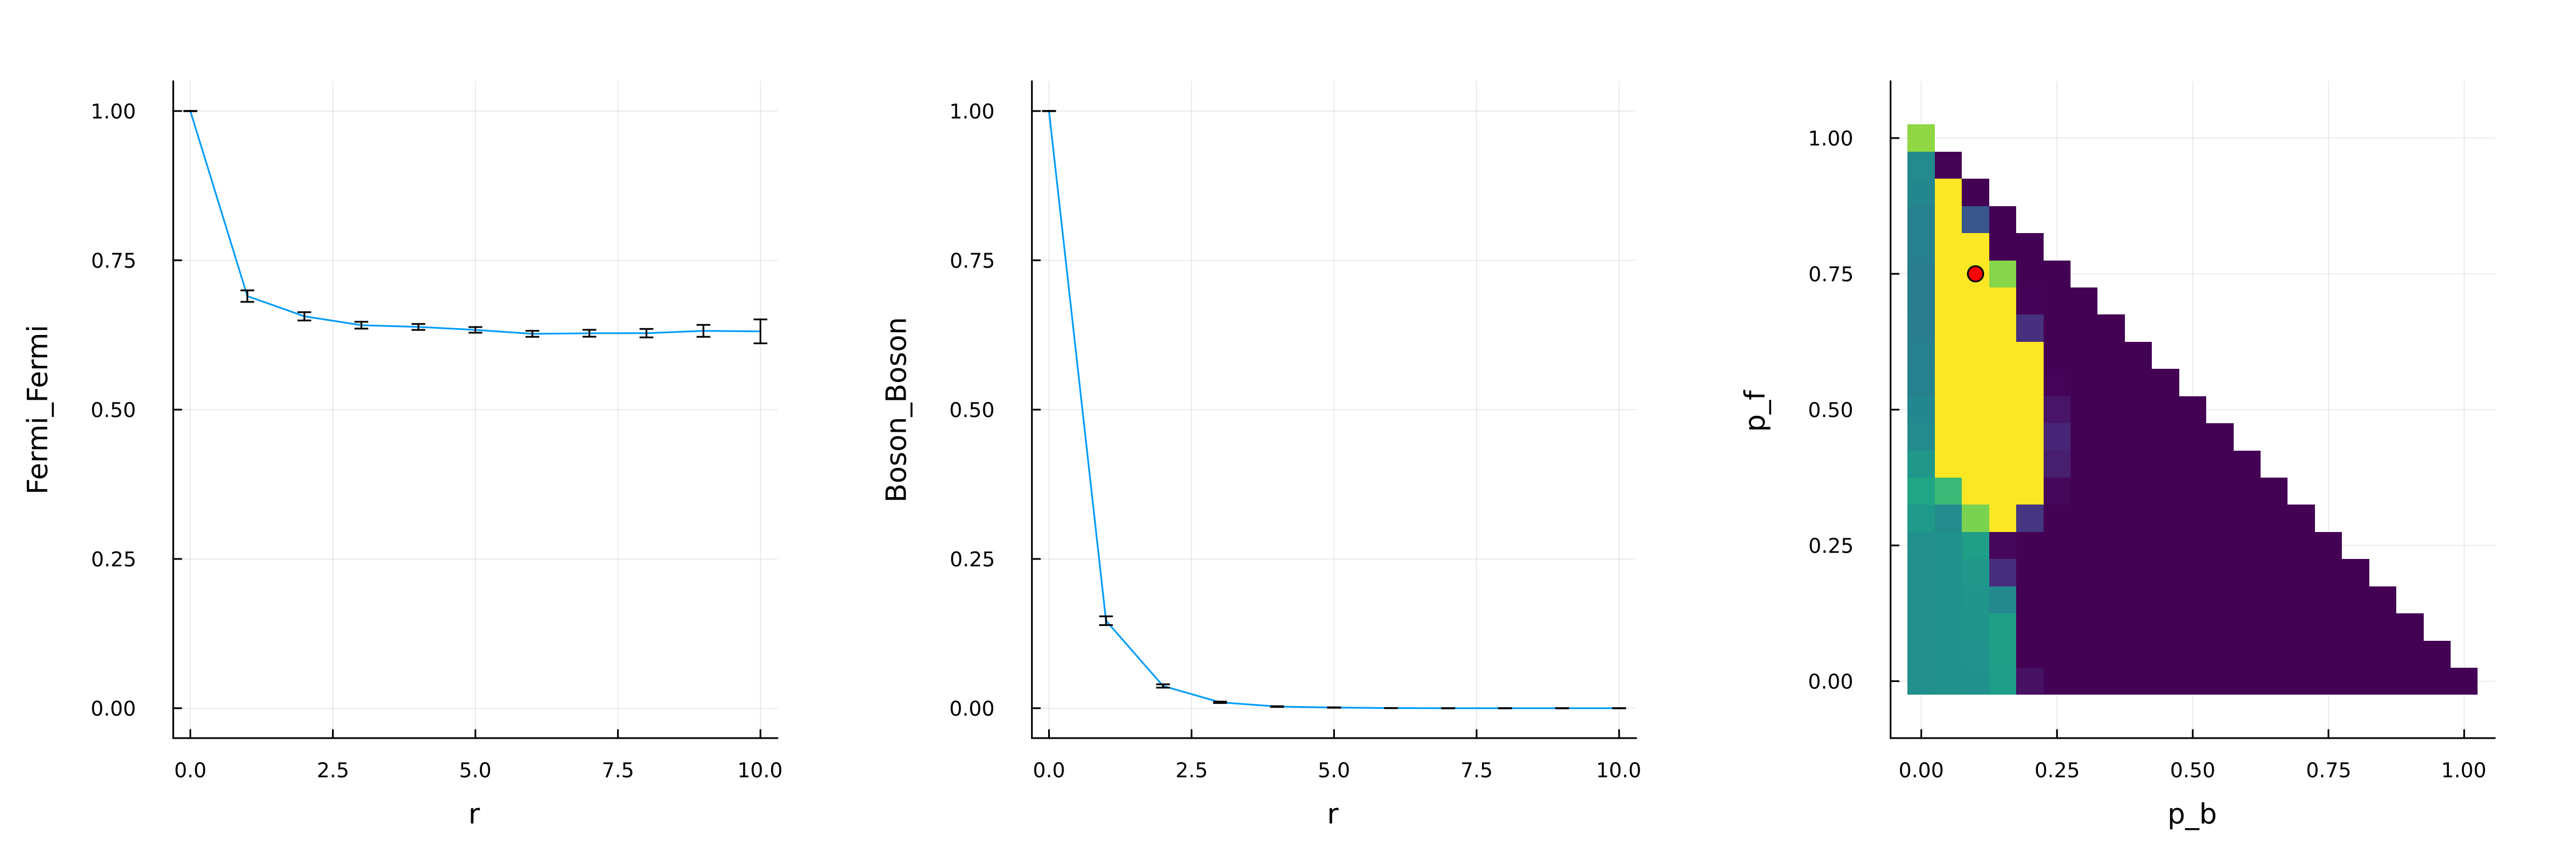

In [41]:
stat = "mean"
ribbon = "err"
probe = 2
p_1 = plot(title = "Fermion-Fermion Correlation Functions", xlabel = "r", ylabel = "Fermi_Fermi")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
ribbon = "err"

p_2 = plot(title = "Boson-Boson Correlation Functions", xlabel = "r", ylabel = "Boson_Boson")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
variable = "TEE"
cut_off = 4
L, p_b, p_f = all_sizes[probe]
L = 30

N = 21
to_map = fill(NaN, N, N)

for key in keys(Data_dict_extra[L])
    p_b, p_f = key
    i = Int(round(p_b*(N-1)))
    j = Int(round(p_f*(N-1)))
    to_map[i + 1, j + 1] = min(Data_dict_extra[L][key][stat][variable], cut_off)
end

p_b = [i/(N-1) for i in 0:(N-1)]
p_f = [i/(N-1) for i in 0:(N-1)]
p_3 = heatmap(p_b, p_f, to_map', aspect_ratio=1, c=:viridis, xlabel="p_b", ylabel="p_f", title="L = $L, $stat $variable", cbar = false)
L, p_b, p_f = all_sizes[probe]
p_3 = scatter!([p_b], [p_f], markersize = 5, legend = false, color = :red, label = "p_b = $p_b, p_f = $p_f")



plot(p_1, p_2, p_3, layout = (1,3), size = (1500, 500), title= "", dpi = 300, legend = false, left_margin = 10Plots.mm, right_margin = 10Plots.mm, top_margin = 10Plots.mm, bottom_margin = 10Plots.mm)
#savefig("Plots/Corr_Funcs_Probe:$(probe).pdf")

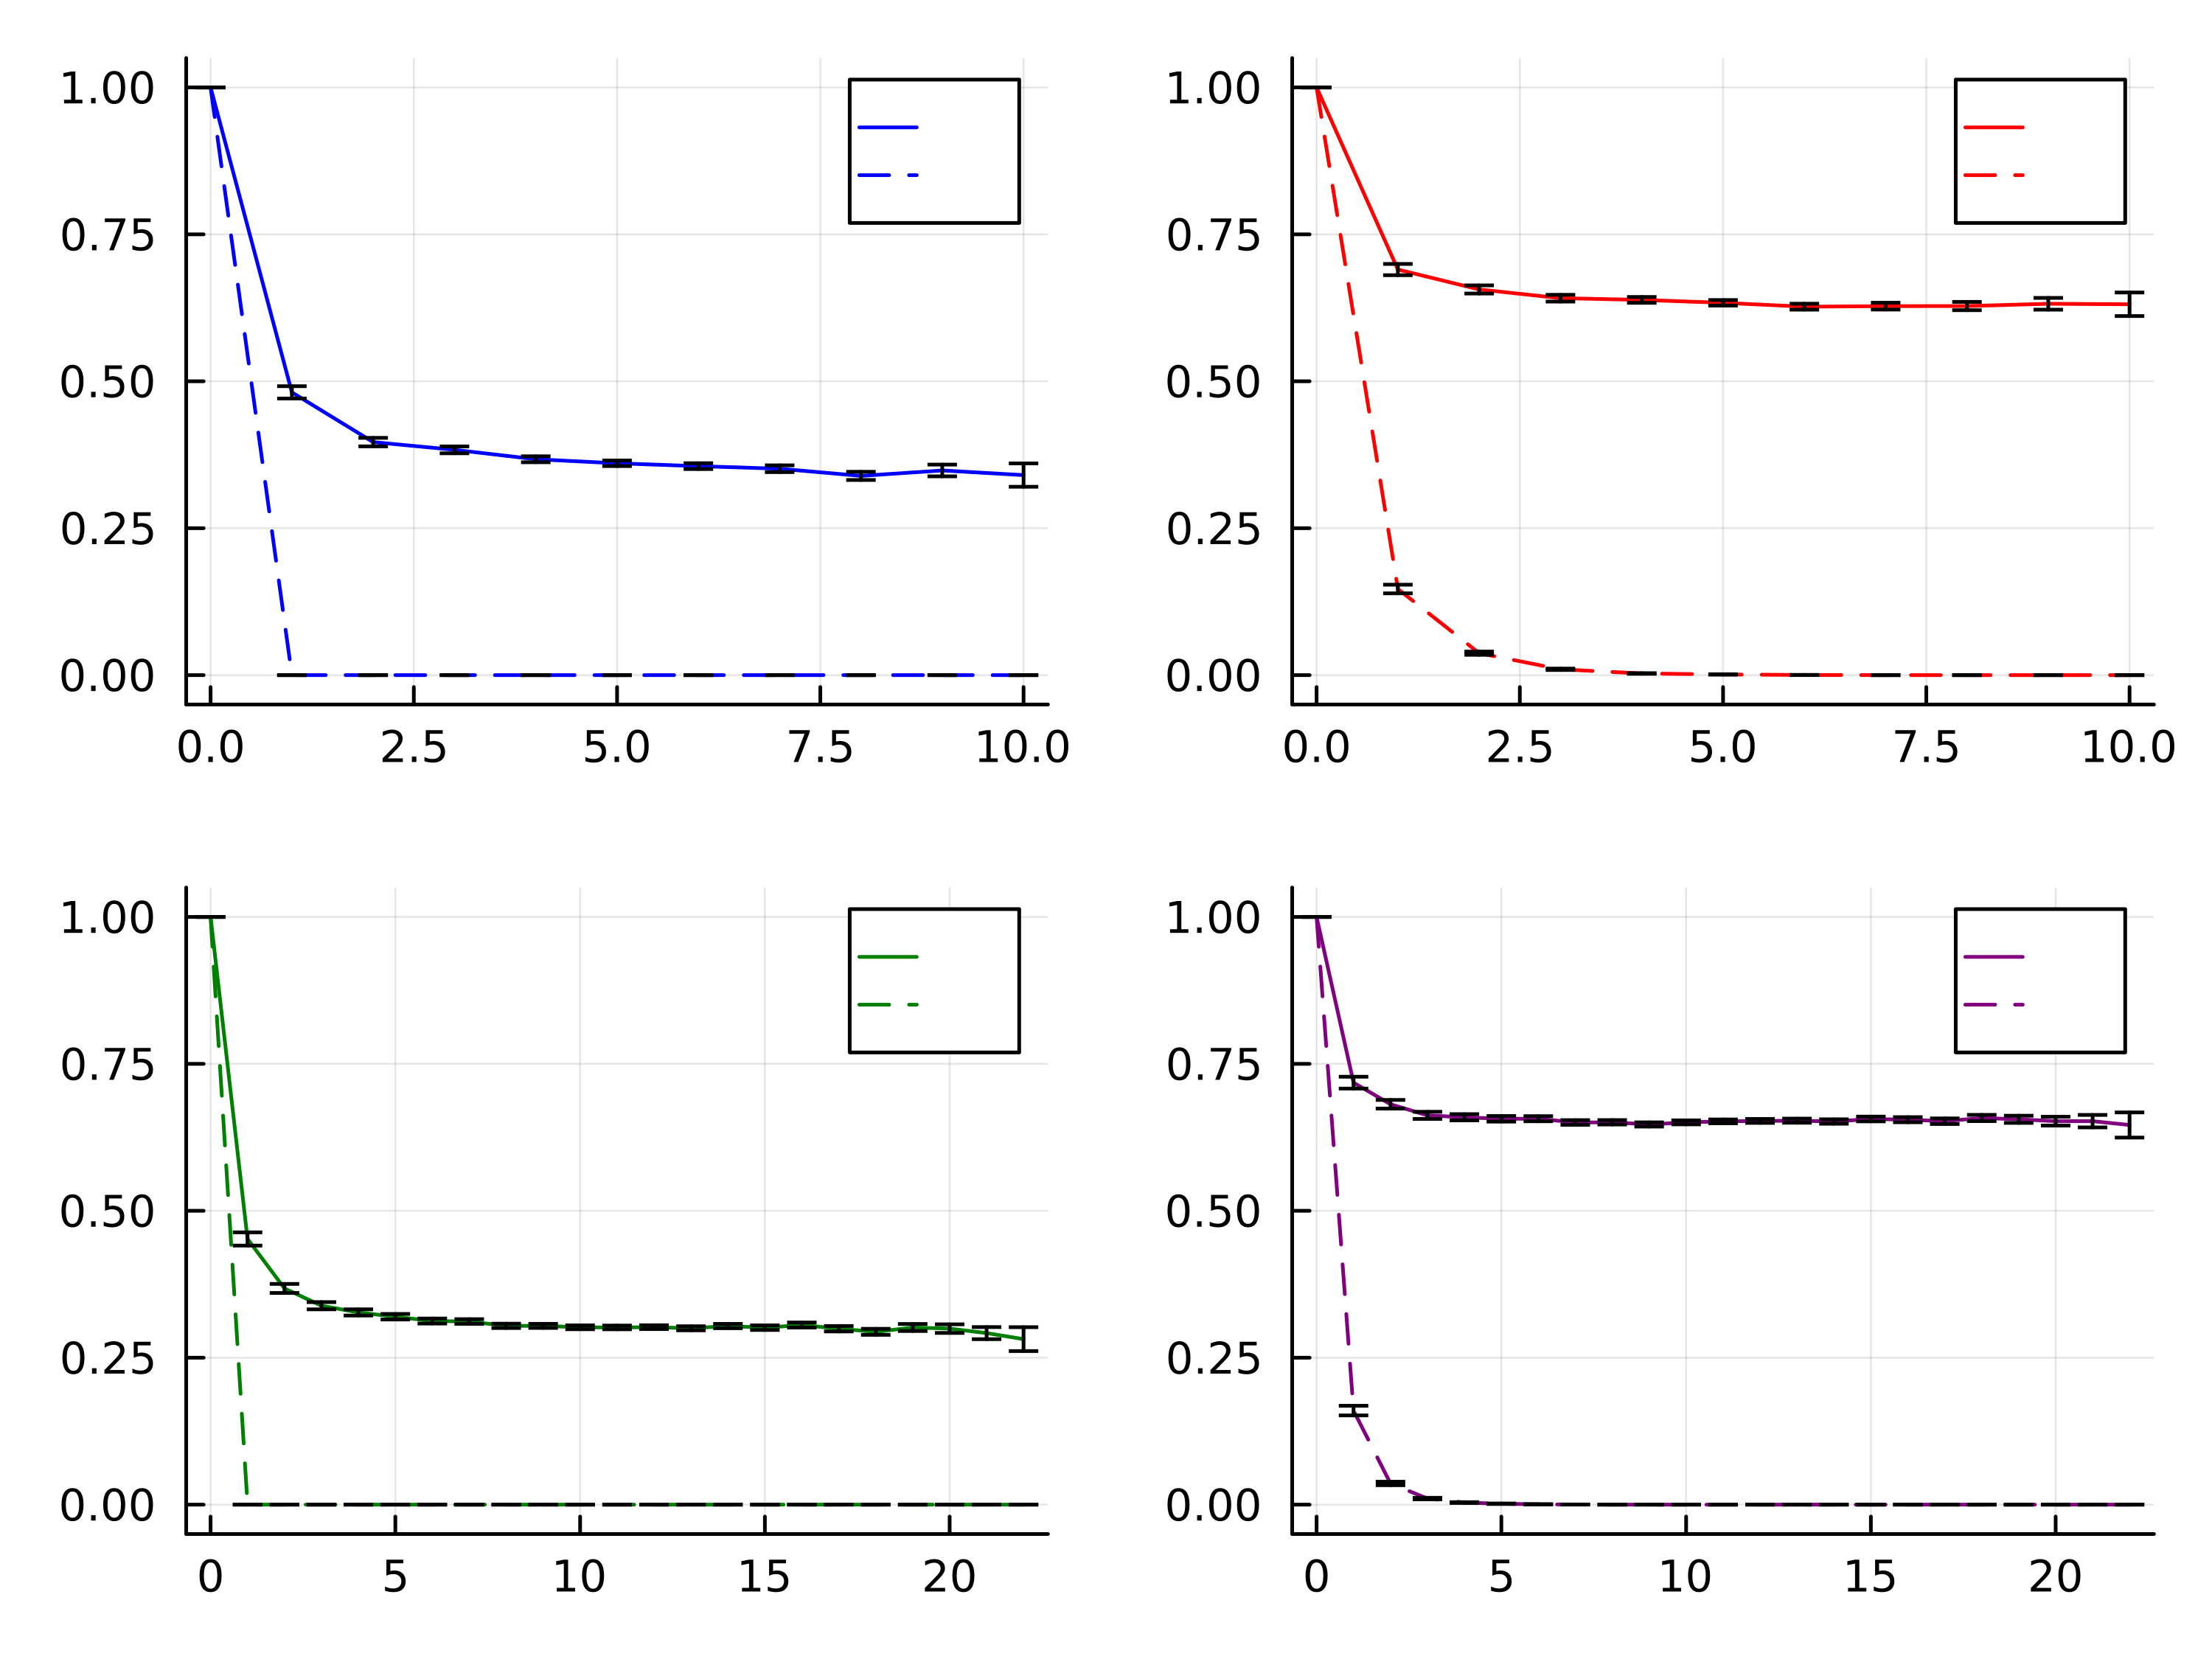

In [42]:
stat = "mean"
ribbon = "err"
probe = 1
p_1 = plot()

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:blue)
end

stat = "mean"
ribbon = "err"

p_1 = plot!(title = "Boson-Boson Correlation Functions", xlabel = "", ylabel = "")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:blue, line=:dash)
end

stat = "mean"
ribbon = "err"
probe = 2
p_2 = plot()

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:red)
end

stat = "mean"
ribbon = "err"

p_2 = plot!(title = "Boson-Boson Correlation Functions", xlabel = "", ylabel = "")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:red, line=:dash)
end

stat = "mean"
ribbon = "err"
probe = 3
p_3 = plot()

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_3 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:green)
end

stat = "mean"
ribbon = "err"

p_3 = plot!(title = "Boson-Boson Correlation Functions", xlabel = "", ylabel = "")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_3 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:green, line=:dash)
end

stat = "mean"
ribbon = "err"
probe = 4
p_4 = plot()

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_4 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:purple)
end

stat = "mean"
ribbon = "err"

p_4 = plot!(title = "Boson-Boson Correlation Functions", xlabel = "", ylabel = "")

for size_key in all_sizes[[probe]]
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    p_4 = plot!(x_axis, y_axis, yerror = y_err, label = "      ", ylim = (-0.05, 1.05), color=:purple, line=:dash)
end

plot(p_1, p_2, p_3, p_4, layout = (2,2), size = (600, 450), title= "", dpi = 500, margins = 2Plots.mm)
#savefig("Plots/Corr_Funcs_Probe:all.pdf")


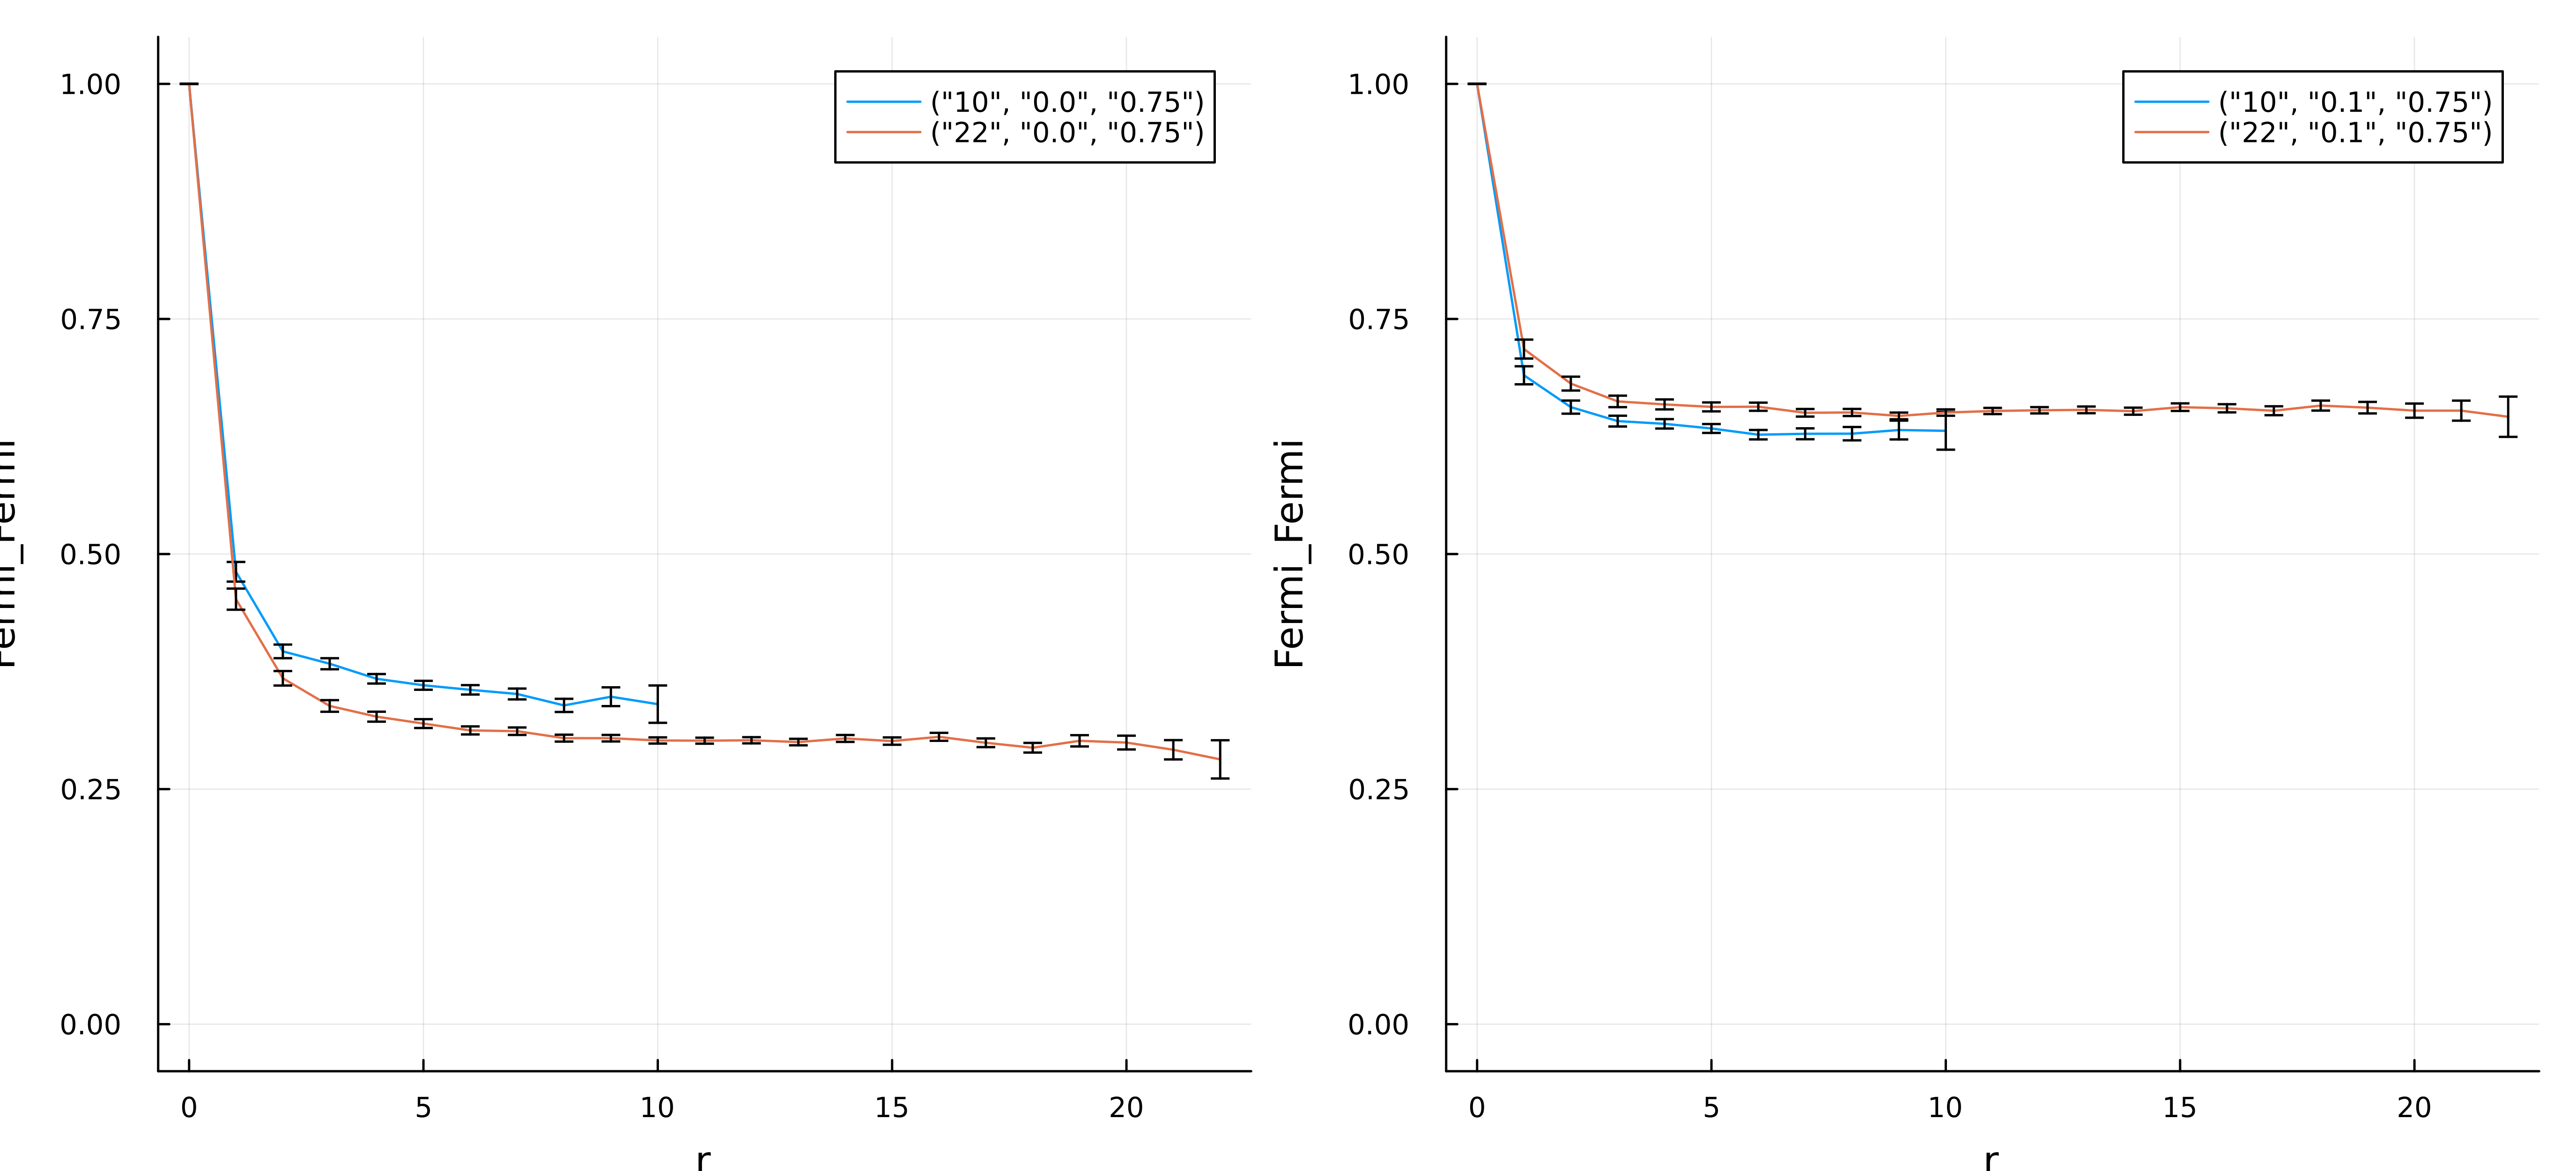

In [47]:
stat = "mean"
ribbon = "err"
L_array = [10, 22]
p_b = 0.00
p_f = 0.75

p_1 = plot(title = "Fermion-Fermion Correlation Functions", xlabel = "r", ylabel = "Fermi_Fermi")

for L in L_array
    size_key = (L, p_b, p_f)
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_1 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

stat = "mean"
ribbon = "err"
L_array = [10, 22]
p_b = 0.10
p_f = 0.75

p_2 = plot(title = "Fermion-Fermion Correlation Functions", xlabel = "r", ylabel = "Fermi_Fermi")

for L in L_array
    size_key = (L, p_b, p_f)
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    p_2 = plot!(x_axis, y_axis, yerror = y_err, label = size_key, ylim = (-0.05, 1.05))
end

plot(p_1, p_2, layout = (1,2), size = (1100, 500), title= "", dpi = 500, margins = 2Plots.mm)

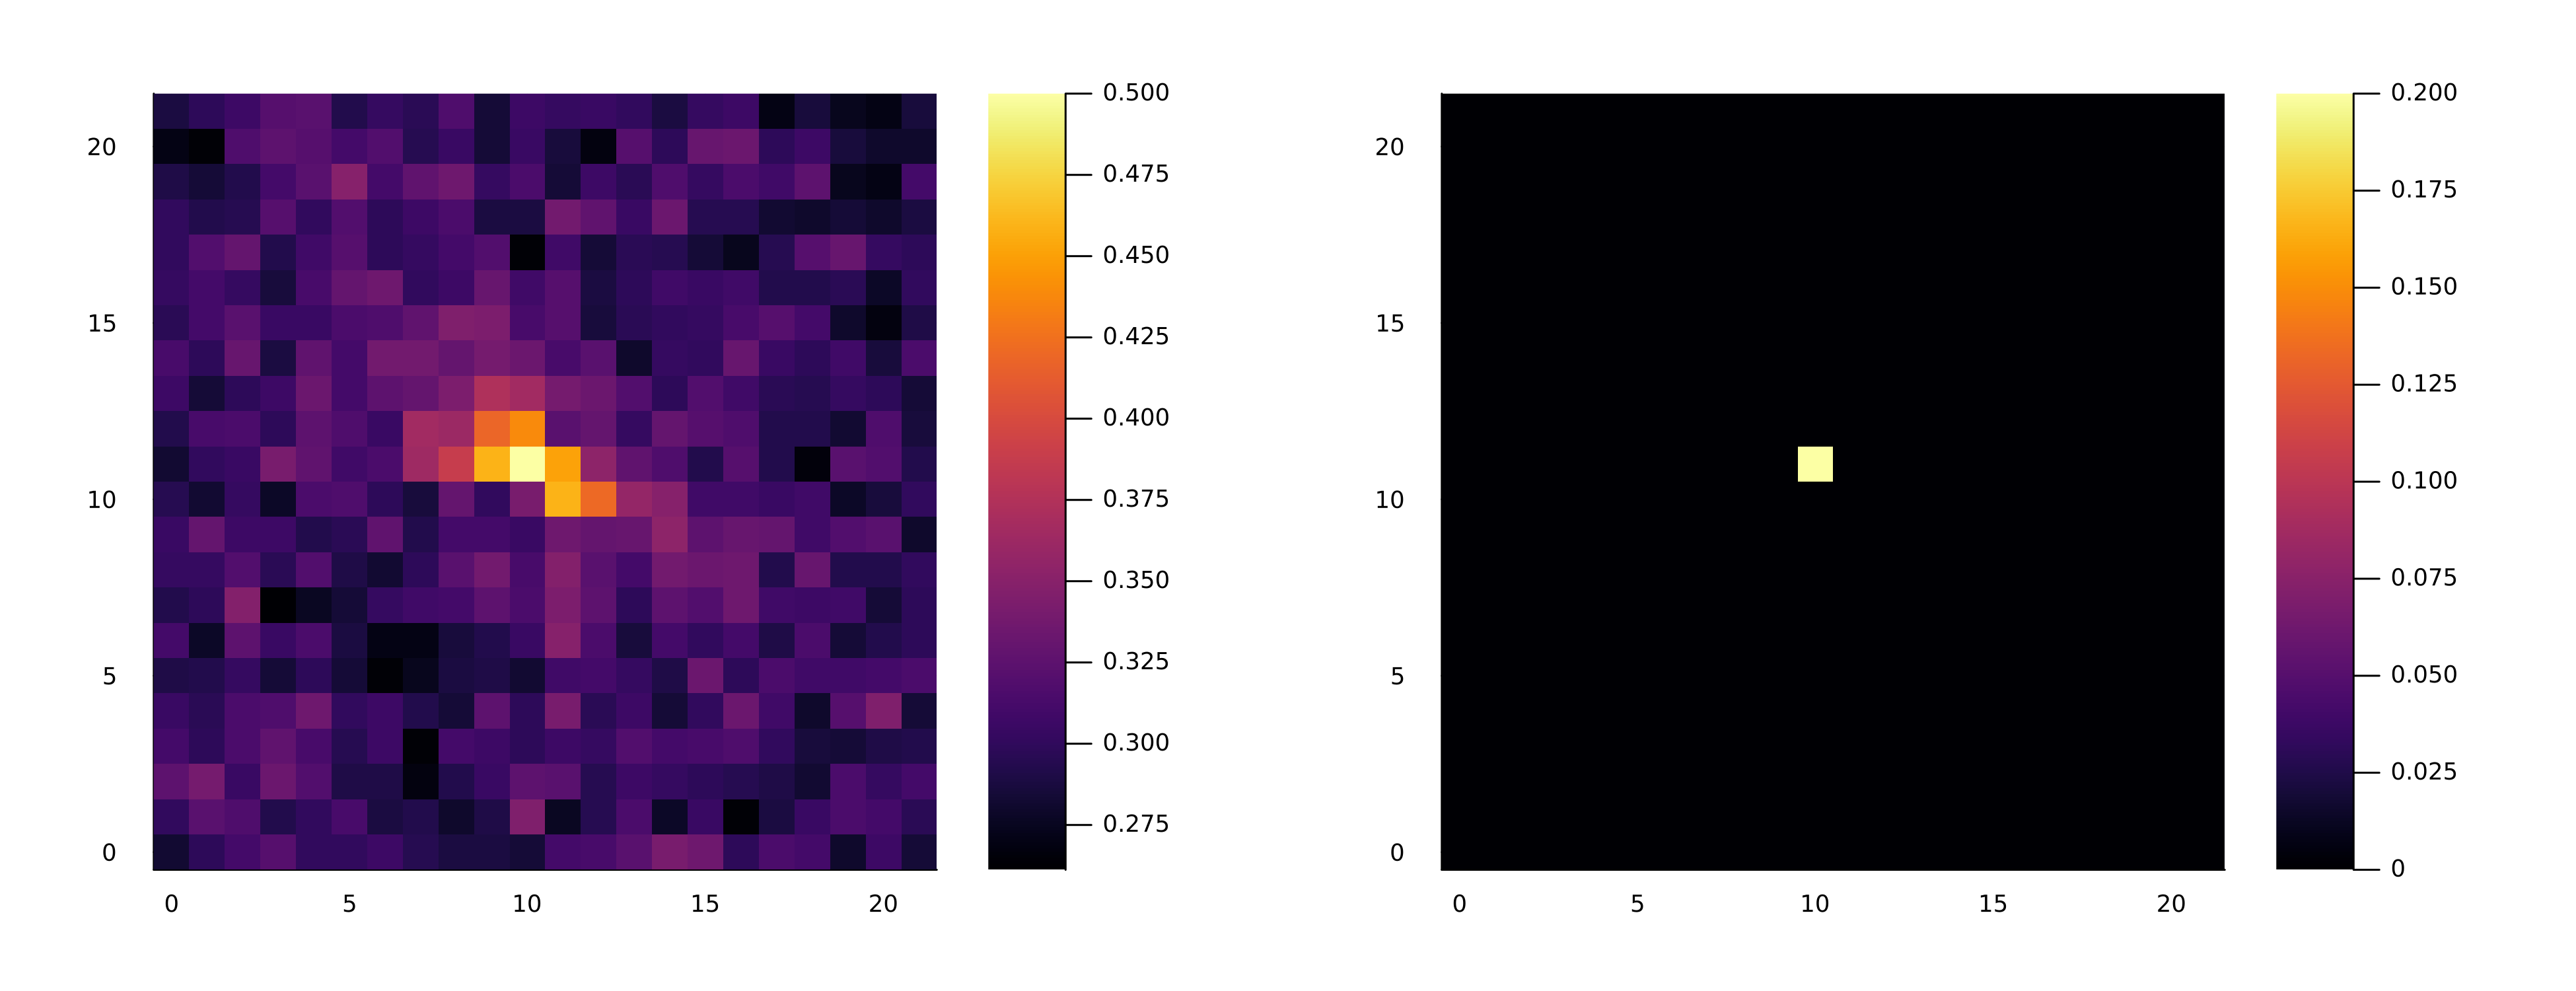

In [44]:

L = 22
sizekey = (L, 0.00, 0.75)
stat = "mean"

z_axis = FF_stats_2d[sizekey][stat]
xy_axis = FF_stats_2d[sizekey]["xy_axis"]

x = [xy[1] for xy in xy_axis]
x = x[1:L:end]
y = [xy[2] for xy in xy_axis]
y = y[1:L]
z_axis = circshift(z_axis, floor(Int, (L-1)*L/2))
z = reshape(z_axis, (L, L))
z_cutoff = 0.5

p_1 = heatmap(x, y, min.(z, z_cutoff))

z_axis = BB_stats_2d[sizekey][stat]
xy_axis = BB_stats_2d[sizekey]["xy_axis"]

x = [xy[1] for xy in xy_axis]
x = x[1:L:end]
y = [xy[2] for xy in xy_axis]
y = y[1:L]
z_axis = circshift(z_axis, floor(Int, (L-1)*L/2))
z = reshape(z_axis, (L, L))
z_cutoff = 0.2

p_2 = heatmap(x, y, min.(z, z_cutoff))

plot(p_1, p_2, layout = (1,2), size = (1300, 500), title= "", dpi = 300, legend = false, left_margin = 10Plots.mm, right_margin = 10Plots.mm, top_margin = 10Plots.mm, bottom_margin = 10Plots.mm)

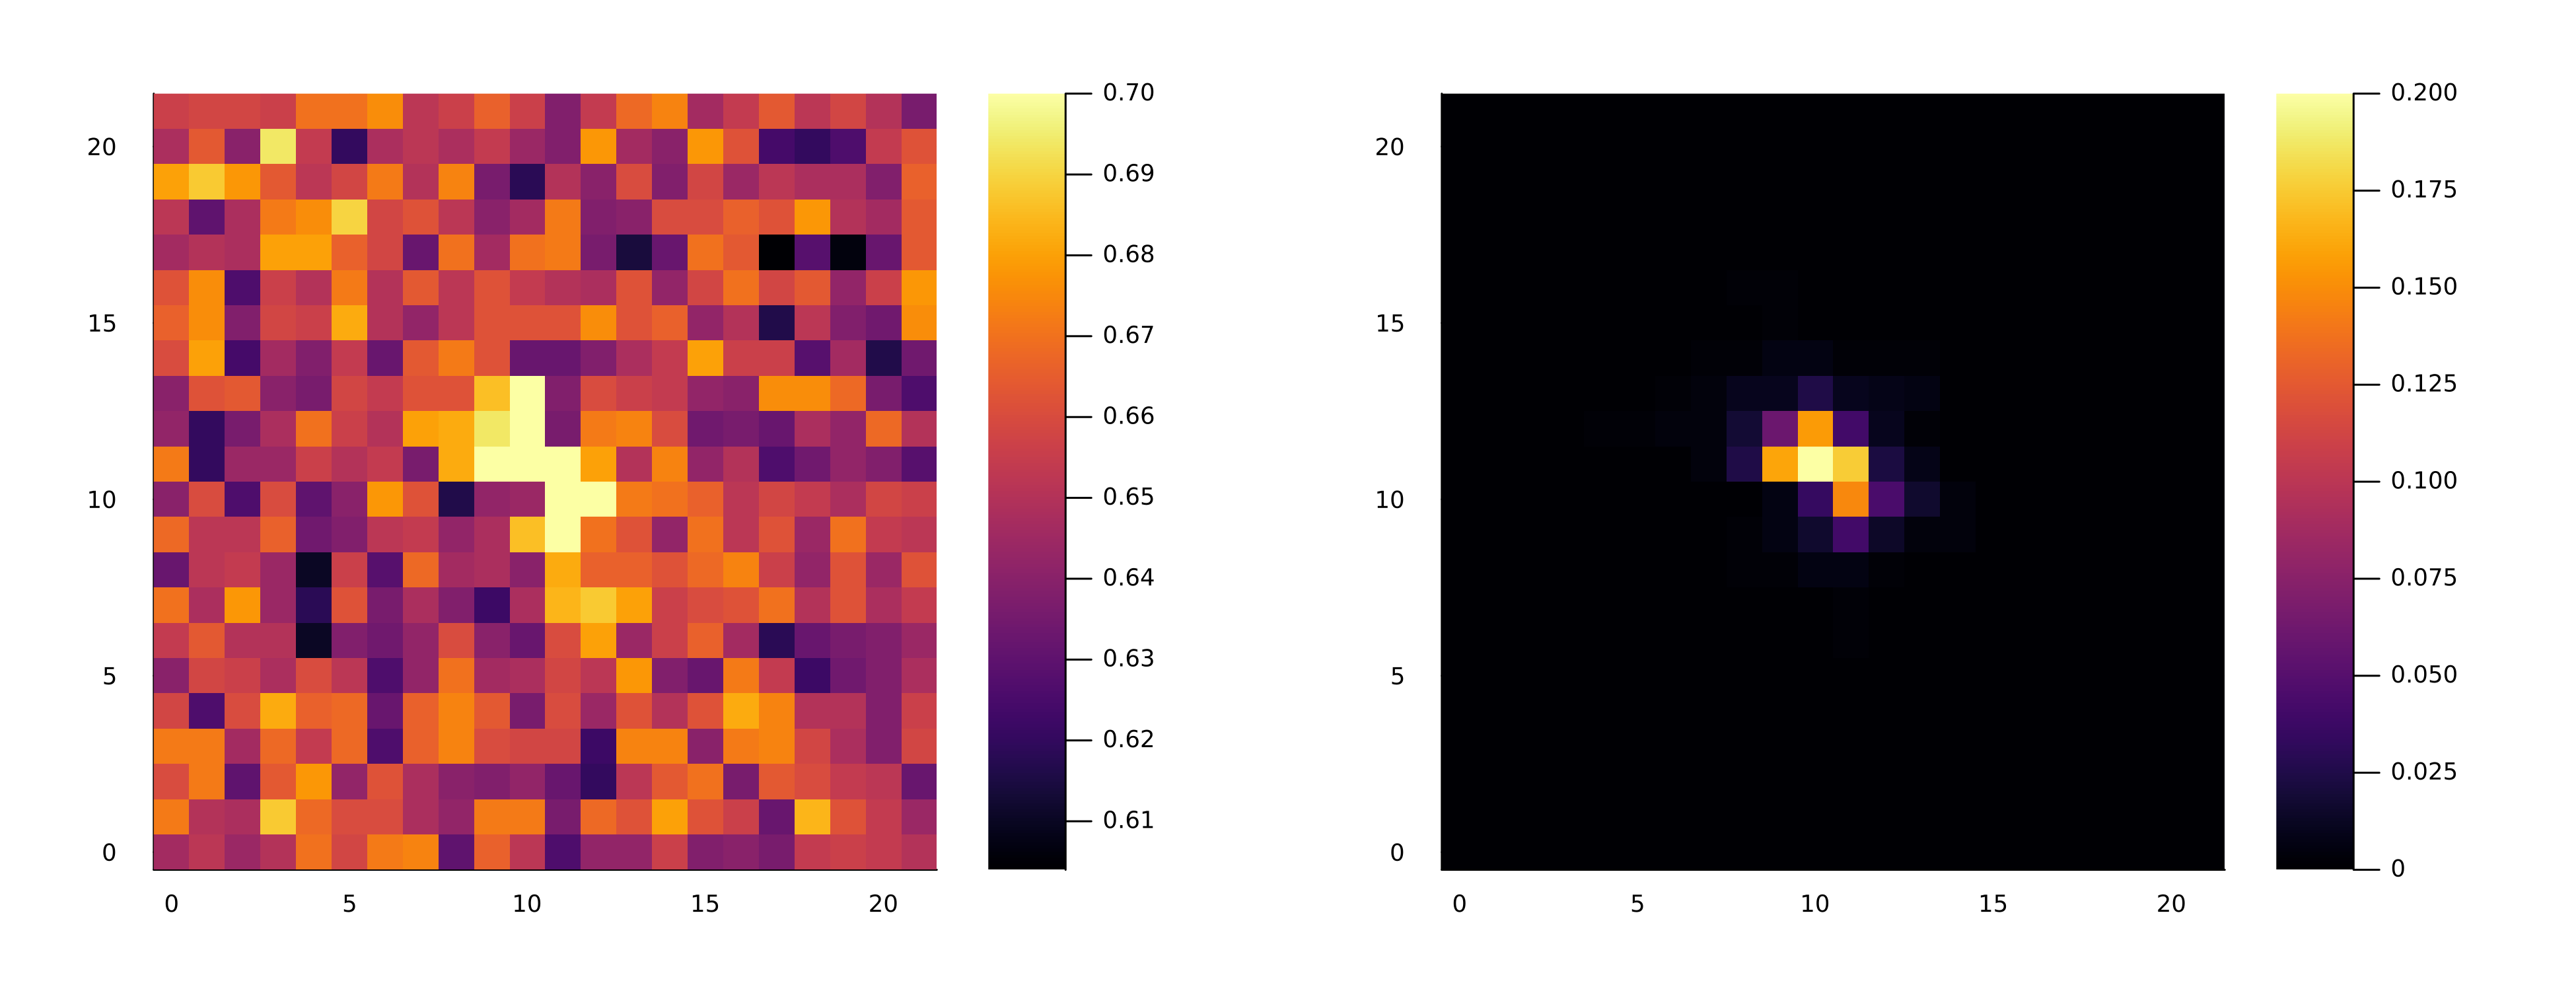

In [45]:
L = 22
sizekey = (L, 0.10, 0.75)
stat = "mean"

z_axis = FF_stats_2d[sizekey][stat]
xy_axis = FF_stats_2d[sizekey]["xy_axis"]

x = [xy[1] for xy in xy_axis]
x = x[1:L:end]
y = [xy[2] for xy in xy_axis]
y = y[1:L]
z_axis = circshift(z_axis, floor(Int, (L-1)*L/2))
z = reshape(z_axis, (L, L))
z_cutoff = 0.7

p_1 = heatmap(x, y, min.(z, z_cutoff))

z_axis = BB_stats_2d[sizekey][stat]
xy_axis = BB_stats_2d[sizekey]["xy_axis"]

x = [xy[1] for xy in xy_axis]
x = x[1:L:end]
y = [xy[2] for xy in xy_axis]
y = y[1:L]
z_axis = circshift(z_axis, floor(Int, (L-1)*L/2))
z = reshape(z_axis, (L, L))
z_cutoff = 0.2

p_2 = heatmap(x, y, min.(z, z_cutoff))

plot(p_1, p_2, layout = (1,2), size = (1300, 500), title= "", dpi = 300, legend = false, left_margin = 10Plots.mm, right_margin = 10Plots.mm, top_margin = 10Plots.mm, bottom_margin = 10Plots.mm)